In [1]:
!pip install -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:

# Imports
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split



LR=0.0001
# dataset config
batch_size = 32
generator=torch.Generator().manual_seed(42) # Can be included for reproducability

In [4]:

import numpy as np
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [5]:
_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

NUM_CLASSES = 0

def getTrainingSet(dataset_name):
  if dataset_name == 'CIFAR-10':
    print("in cifar-10")
    NUM_CLASSES=10

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform_train)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=transform_test)
    
    
    

    trainset, validset = torch.utils.data.random_split(trainset, 
                                                      [int(len(trainset)*0.8),len(trainset)- 
                                                      int(len(trainset)*0.8)], generator=generator)
    
  elif dataset_name == 'STL10':
    NUM_CLASSES=10
    
    trainset = torchvision.datasets.STL10(root='./data', split='train',
                                          download=True, transform=transform_train)

    testset = torchvision.datasets.STL10(root='./data', split='test',
                                          download=True, transform=transform_train)
    

    trainset, validset = torch.utils.data.random_split(trainset, 
                                                      [int(len(trainset)*0.8),len(trainset)- 
                                                      int(len(trainset)*0.8)], generator=generator)
    

  elif dataset_name == 'Caltech101':
    NUM_CLASSES=101
    !gdown https://drive.google.com/uc?id=1DX_XeKHn3yXtZ18DD7qc1wf-Jy5lnhD5
    !unzip -qq '101_ObjectCategories.zip' 

    PATH = '101_ObjectCategories/'

    transform = transforms.Compose(
      [transforms.CenterCrop(256),
      transforms.Resize((64,64)),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    totalset = torchvision.datasets.ImageFolder(PATH, transform=transform_train)

    X, y = zip(*totalset)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, 
                                                      stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, 
                                                    test_size = 0.5, 
                                                    stratify=y_val)

    trainset, validset, testset = list(zip(X_train, y_train)), list(zip(X_val, y_val)), list(zip(X_test, y_test))




  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
  validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                            shuffle=False,num_workers=2)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
  return trainset, testset, trainloader, testloader

In [6]:
train_ds, test_ds, train_loader, test_loader = getTrainingSet('CIFAR-10')

in cifar-10
Files already downloaded and verified
Files already downloaded and verified


In [7]:
from transformers import BeitModel,BeitFeatureExtractor
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F

class BeitForImageClassification(nn.Module):
    def __init__(self, num_labels=10):
        super(BeitForImageClassification, self).__init__()
        self.beit = BeitModel.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.beit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values):
        outputs = self.beit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        return logits

In [8]:

BATCH_SIZE = batch_size
LEARNING_RATE = 0.0001

In [9]:
from transformers import BeitFeatureExtractor
import torch.nn as nn
import torch
# Define Model
model = BeitForImageClassification(10)
# Feature Extractor
feature_extractor = BeitFeatureExtractor.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')
# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Use GPU if available  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
if torch.cuda.is_available():
    model.cuda() 

Some weights of the model checkpoint at microsoft/beit-base-patch16-224-pt22k-ft22k were not used when initializing BeitModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BeitModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BeitModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
def train(epoch):
  model.train()
  correct_images = 0
  total_images = 0
  training_loss = 0
  losses = 0
  for batch_index, (images, labels) in enumerate(tqdm(train_loader)):
    optimizer.zero_grad()
    x = np.split(np.squeeze(np.array(images)), BATCH_SIZE)
    # Remove unecessary dimension
    for index, array in enumerate(x):
      x[index] = np.squeeze(array)
    # Apply feature extractor, stack back into 1 tensor and then convert to tensor
    x = torch.tensor(np.stack(feature_extractor(x)['pixel_values'], axis=0))
    images, labels = x.to(device), labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    training_loss += loss.item()
    _, predicted = outputs.max(1)
    total_images += labels.size(0)
    correct_images += predicted.eq(labels).sum().item()
  print('Epoch: %d, Loss: %.3f, '
              'Accuracy: %.3f%% (%d/%d)' % (epoch, training_loss/(batch_index+1),
                                       100.*correct_images/total_images, correct_images, total_images))
  return training_loss/(batch_index+1), 100.*correct_images/total_images



In [11]:
def test():
    test_loss = 0
    total_images = 0
    correct_images = 0
    total_loss = 0
    model.eval()
    with torch.no_grad():
      for batch_index, (images, labels) in enumerate(tqdm(test_loader)):
        x = np.split(np.squeeze(np.array(images)), 32)
        # Remove unecessary dimension
        for index, array in enumerate(x):
          x[index] = np.squeeze(array)
        # Apply feature extractor, stack back into 1 tensor and then convert to tensor
        x = torch.tensor(np.stack(feature_extractor(x)['pixel_values'], axis=0))
        images, labels = x.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total_images += labels.size(0)
        correct_images += predicted.eq(labels).sum().item()
        #print(batch_index, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #           % (test_loss/(batch_index+1), 100.*correct_images/total_images, correct_images, total_images))
    test_accuracy = 100.*correct_images/total_images
    print("accuracy of test set is",test_accuracy)
    return test_accuracy

In [12]:
# Model

accuracy_test = []
loss = []
train_acc = []
model.to(device)
    
criterion = nn.CrossEntropyLoss()

#RETURN LOSS AFTER EACH EPOCH
for epoch in range(60):
    epoch_loss, epoch_acc = train(epoch)
    loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    accuracy_test.append(test())
        

100%|██████████| 1250/1250 [13:55<00:00,  1.50it/s]


Epoch: 0, Loss: 3.165, Accuracy: 19.125% (7650/40000)


100%|█████████▉| 312/313 [01:23<00:00,  3.75it/s]


ValueError: ignored

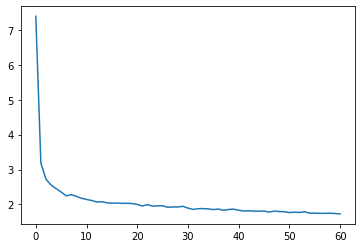

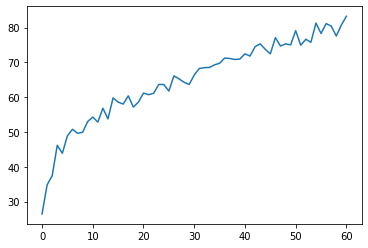

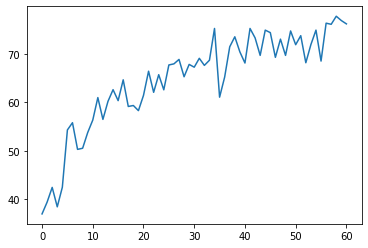

In [53]:
from matplotlib import pyplot as plt
plt.plot(stl_loss)
plt.show()
plt.plot(stl_train_acc)
plt.show()
plt.plot(stl_accuracy_test)